In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# --- Load metrics ---
media_path = 'data/media_samples_train'
metrics = pd.read_csv(os.path.join(media_path, 'media_metrics.csv'))

# --- List LBM result files ---
lbm_results_path = 'data/lbm_simulation_results_train'
lbm_paths = sorted(glob.glob(os.path.join(lbm_results_path, "*.npz")))
lbm_filenames = [os.path.basename(p) for p in lbm_paths]

# --- Filter metrics for percolating samples ---
mask = metrics["percolates_x"] & metrics["percolates_y"]
metrics_filtered = metrics.loc[mask].reset_index(drop=True)

# --- Assign filenames to metrics_filtered to match LBM files ---
metrics_filtered["filename"] = lbm_filenames

# --- Load LBM results into a DataFrame ---
new_records = []

for path in lbm_paths:
    data = np.load(path)
    record = {}

    record["filename"] = os.path.basename(path)

    for key in data.files:
        arr = data[key]

        if key in ("ux_physical", "uy_physical"):
            continue

        if key == "K":
            record["K_xx"] = arr[0, 0]
            record["K_xy"] = arr[0, 1]
            record["K_yx"] = arr[1, 0]
            record["K_yy"] = arr[1, 1]
        else:
            record[key] = arr.item() if arr.ndim == 0 else arr

    new_records.append(record)

lbm_df = pd.DataFrame(new_records)

# --- Merge metrics and LBM results ---
df = metrics_filtered.merge(lbm_df, on="filename", how="inner")

In [3]:
display(df.head())

,seed,porosity,sigma,percolates_x,percolates_y,filename,K_xx,K_xy,K_yx,K_yy,...,Ma_x,Ma_y,Re_lattice_x,Re_lattice_y,dt,tau,Re_phys_x,Re_phys_y,dx,F_lattice
0,0,0.452942,0.1,True,True,simulation_result_0.npz,4.297723e-11,-1.944651e-12,-1.944650e-12,4.003890e-11,...,1.676605e-09,1.556544e-09,9.292687e-07,8.627240e-07,0.000008,0.9,9.292687e-07,8.627240e-07,0.000008,8.477105e-10
1,4,0.623108,0.1,True,True,simulation_result_1.npz,9.598487e-11,-3.402397e-12,-3.402397e-12,2.159273e-10,...,5.204170e-09,1.194627e-08,2.884444e-06,6.621297e-06,0.000008,0.9,2.884444e-06,6.621297e-06,0.000008,8.477105e-10
2,5,0.733276,0.1,True,True,simulation_result_10.npz,1.391897e-10,4.951561e-11,4.951560e-11,1.324858e-10,...,1.014291e-08,9.782569e-09,5.621770e-06,5.422050e-06,0.000008,0.9,5.621770e-06,5.422050e-06,0.000008,8.477105e-10
3,6,0.780334,0.1,True,True,simulation_result_11.npz,4.888483e-11,1.087484e-11,1.087485e-11,4.133617e-11,...,2.557622e-09,2.234551e-09,1.417578e-06,1.238514e-06,0.000008,0.9,1.417578e-06,1.238514e-06,0.000008,8.477105e-10
4,7,0.767212,0.1,True,True,simulation_result_12.npz,2.102745e-10,-3.699356e-11,-3.699355e-11,3.909602e-10,...,1.077551e-08,2.201150e-08,5.972396e-06,1.220001e-05,0.000008,0.9,5.972396e-06,1.220001e-05,0.000008,8.477105e-10


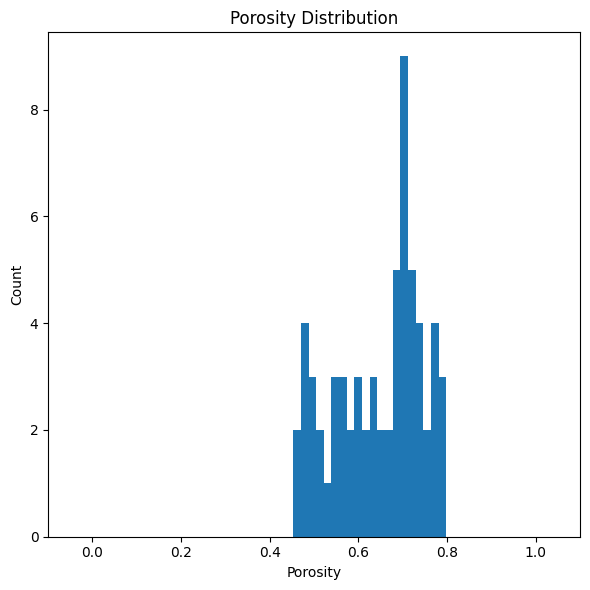

In [4]:
# porosity
fig = plt.figure(figsize=(6,6))
plt.title('Porosity Distribution')
mask = (metrics['percolates_x']) & (metrics['percolates_y'])
plt.hist(metrics.loc[mask,'porosity'],bins=20)
plt.xlabel('Porosity')
plt.ylabel('Count')
plt.xlim(-0.1,1.1)
plt.tight_layout()
plt.show()

/tmp/ipykernel_425801/1462095344.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


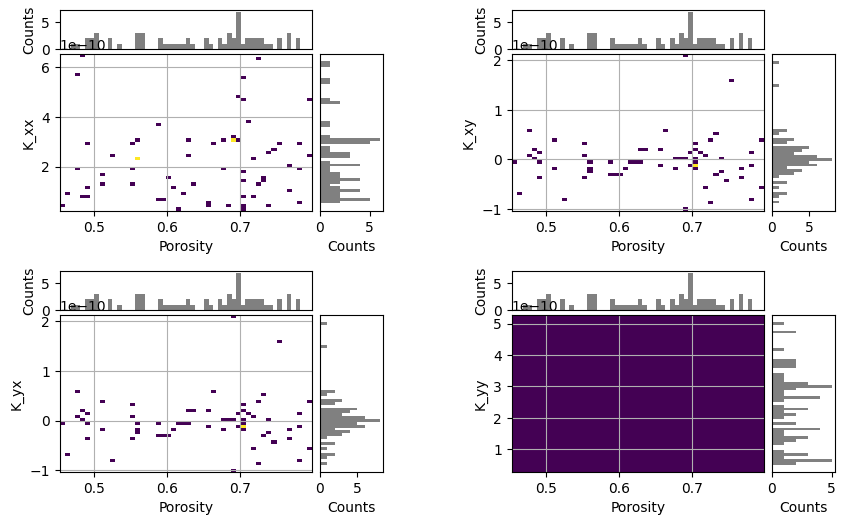

In [6]:
# permeability over porosity
from matplotlib import gridspec, colors

labels = [['K_xx', 'K_xy'], ['K_yx', 'K_yy']]

fig = plt.figure(figsize=(10, 6))
outer_gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.3)

for i in range(2):
    for j in range(2):
        # Outer position
        outer_pos = outer_gs[i, j]

        # Create inner GridSpec for this component
        inner_gs = gridspec.GridSpecFromSubplotSpec(
            2, 2, subplot_spec=outer_pos,
            width_ratios=[4, 1],
            height_ratios=[1, 4],
            wspace=0.05, hspace=0.05
        )

        ax_histx = fig.add_subplot(inner_gs[0, 0])
        ax_scatter = fig.add_subplot(inner_gs[1, 0])
        ax_histy = fig.add_subplot(inner_gs[1, 1])

        x = df['porosity'].values
        y = df[labels[i][j]].values

        # 2D histogram
        h = ax_scatter.hist2d(x, y, bins=50, cmap='viridis', norm=colors.LogNorm())

        # 1D histograms
        ax_histx.hist(x, bins=50, color='gray')
        ax_histx.set_xticks([])
        ax_histx.set_ylabel('Counts')

        ax_histy.hist(y, bins=50, color='gray', orientation='horizontal')
        ax_histy.set_yticks([])
        ax_histy.set_xlabel('Counts')

        ax_scatter.set_xlabel('Porosity')
        ax_scatter.set_ylabel(labels[i][j])
        ax_scatter.grid(True)

plt.tight_layout()
plt.show()